### Contents of the data file

It data contains the following 6 fields:

- target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
- ids: The id of the tweet ( 2087)
- date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- flag: The query (lyx). If there is no query, then this value is NO_QUERY.
- user: the user that tweeted (robotickilldozr)
- text: the text of the tweet (Lyx is cool)

#### For this analysis we will choose the text column and the target column.
- I choose tweets corresponding to positive target (positive sentiment). We extract topics  hidden in these texts using Latent Dirichlet Allocation (LDA).
- I repeat the abobe analysis using texts with negative polarirty (negative sentiment).
- Finally I visulize the results of the analysis by plotting a wordcloud. 

In [1]:
import pandas as pd
import numpy as np
import re, string
# vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

### Read the data file

In [2]:
df=pd.read_csv("training.csv",encoding="cp1252", header = None)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   0       1600000 non-null  int64 
 1   1       1600000 non-null  int64 
 2   2       1600000 non-null  object
 3   3       1600000 non-null  object
 4   4       1600000 non-null  object
 5   5       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


### No null values, rename the columns according to provided description

In [4]:
df.rename(columns={0: 'target', 1: 'ids',2:'date',3:'flag',4:'user',5:'text'}, inplace=True)

In [5]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
df.target.value_counts()

4    800000
0    800000
Name: target, dtype: int64

#### Use NLTK to tokenize

In [7]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import string
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/franciumpnc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet

In [9]:
punctuation = list(string.punctuation)
my_stopwords = nltk.corpus.stopwords.words('english')+ punctuation + ['rt', 'via']

#newStopWords = ['u','r']
#my_stopwords.extend(newStopWords)


word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

# cleaning master function
def clean_tweet(tweet, bigrams=False):
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = tweet.lower() # lower case
    tweet = re.sub('['+my_punctuation + ']+', ' ', tweet) # strip punctuation
    tweet = re.sub('\s+', ' ', tweet) #remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet) # remove numbers
    tweet = re.sub("\'","",tweet) # Remove distracting single quotes
    
    tweet_token_list = [word for word in tweet.split(' ') 
                        if word not in my_stopwords] # remove stopwords
    
    tweet_token_list = [word for word in tweet_token_list 
                        if len(word)>2] # take words of minimum length 2

    
    tweet_token_list = [word_rooter(word) if '#' not in word else word
                        for word in tweet_token_list] # apply word rooter
    
    if bigrams:
        tweet_token_list = tweet_token_list+[tweet_token_list[i]+'_'+tweet_token_list[i+1]
                                            for i in range(len(tweet_token_list)-1)]
    tweet = ' '.join(tweet_token_list)
    return tweet

In [10]:
RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)

def strip_emoji(text):
    return RE_EMOJI.sub(r'', text)

In [11]:
df['clean_tweet'] = df.text.apply(clean_tweet)

In [12]:
df['clean_tweet'] = df.clean_tweet.apply(strip_emoji)

### Separate positive and negative tweets 

In [13]:
dfnegative=df.loc[df.target==0]
dfpositive=df.loc[df.target==4]

In [14]:
print(dfpositive.target.value_counts())

print(dfnegative.target.value_counts())

4    800000
Name: target, dtype: int64
0    800000
Name: target, dtype: int64


### Take the first 10000 tweets from both positive and negative 

In [15]:
dfnegative=dfnegative[:50000]
dfpositive=dfpositive[:50000]

In [16]:
print(dfpositive["text"][:5])
print(dfpositive["clean_tweet"][:5])

800000         I LOVE @Health4UandPets u guys r the best!! 
800001    im meeting up with one of my besties tonight! ...
800002    @DaRealSunisaKim Thanks for the Twitter add, S...
800003    Being sick can be really cheap when it hurts t...
800004      @LovesBrooklyn2 he has that effect on everyone 
Name: text, dtype: object
800000                                        love guy best
800001           meet one besti tonight cant wait girl talk
800002    thank twitter add sunisa got meet hin show are...
800003    sick realli cheap hurt much eat real food plu ...
800004                                       effect everyon
Name: clean_tweet, dtype: object


In [17]:
print(dfnegative["text"][:5])
print(dfnegative["clean_tweet"][:5])

0    @switchfoot http://twitpic.com/2y1zl - Awww, t...
1    is upset that he can't update his Facebook by ...
2    @Kenichan I dived many times for the ball. Man...
3      my whole body feels itchy and like its on fire 
4    @nationwideclass no, it's not behaving at all....
Name: text, dtype: object
0         awww bummer shoulda got david carr third day
1    upset updat facebook text might cri result sch...
2            dive mani time ball manag save rest bound
3                      whole bodi feel itchi like fire
4                                        behav mad see
Name: clean_tweet, dtype: object


In [18]:
#Convert to list
#Positive data
datapositive=dfpositive.clean_tweet.values.tolist()
datapositive[:20]
# Negative data
datanegative=dfnegative.clean_tweet.values.tolist()
datanegative[:20]

['awww bummer shoulda got david carr third day',
 'upset updat facebook text might cri result school today also blah',
 'dive mani time ball manag save rest bound',
 'whole bodi feel itchi like fire',
 'behav mad see',
 'whole crew',
 'need hug',
 'hey long time see ye rain bit bit lol fine thank',
 'nope',
 'que muera',
 'spring break plain citi snow',
 'pierc ear',
 'bear watch thought loss embarrass',
 'count idk either never talk anymor',
 'would first gun realli though zac snyder doucheclown',
 'wish got watch miss premier',
 'holli death scene hurt sever watch film wri director cut',
 'file tax',
 'ahh ive alway want see rent love soundtrack',
 'dear drink forgotten tabl drink']

In [19]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

### Tokenize the cleaned tweets 

In [20]:
"""Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.
Gensim’s simple_preprocess() is great for this. Additionally I have set deacc=True to remove the punctuations."""

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True,min_len=1))  # deacc=True removes punctuations

data_words_positive = list(sent_to_words(datapositive))
data_words_negative = list(sent_to_words(datanegative))

In [21]:
print(dfpositive.text[:4])
print('------')
print(datapositive[:4])
print('------')
print(data_words_positive[:4])

800000         I LOVE @Health4UandPets u guys r the best!! 
800001    im meeting up with one of my besties tonight! ...
800002    @DaRealSunisaKim Thanks for the Twitter add, S...
800003    Being sick can be really cheap when it hurts t...
Name: text, dtype: object
------
['love guy best', 'meet one besti tonight cant wait girl talk', 'thank twitter add sunisa got meet hin show area sweetheart', 'sick realli cheap hurt much eat real food plu friend make soup']
------
[['love', 'guy', 'best'], ['meet', 'one', 'besti', 'tonight', 'cant', 'wait', 'girl', 'talk'], ['thank', 'twitter', 'add', 'sunisa', 'got', 'meet', 'hin', 'show', 'area', 'sweetheart'], ['sick', 'realli', 'cheap', 'hurt', 'much', 'eat', 'real', 'food', 'plu', 'friend', 'make', 'soup']]


In [22]:
import matplotlib.pyplot as plt
def plot_length(data_words):
    sentence_lengths = [len(tokens) for tokens in data_words]
    fig = plt.figure(figsize=(5, 5)) 
    plt.xlabel('Sentence length')
    plt.ylabel('Number of sentences')
    plt.hist(sentence_lengths,bins=50)
    plt.show()

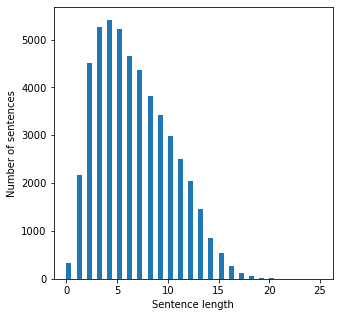

In [23]:
plot_length(data_words_positive)

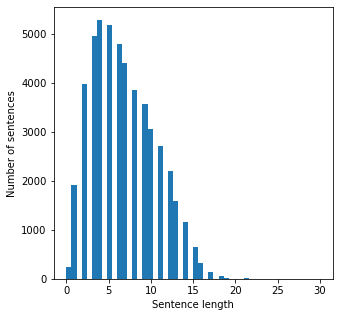

In [24]:
plot_length(data_words_negative)

In [25]:
dfpositive.text.tolist()[0]

'I LOVE @Health4UandPets u guys r the best!! '

In [26]:
"""The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus.
"""
# Create Dictionary
id2word = corpora.Dictionary(data_words_positive)

# Create Corpus
texts = data_words_positive

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
for i in range(0,5):
    print(dfpositive.text.tolist()[i])
    print(data_words_positive[i])
    print(corpus[i])
print('------')    
print('length of vocabulary',len(id2word))

I LOVE @Health4UandPets u guys r the best!! 
['love', 'guy', 'best']
[(0, 1), (1, 1), (2, 1)]
im meeting up with one of my besties tonight! Cant wait!!  - GIRL TALK!!
['meet', 'one', 'besti', 'tonight', 'cant', 'wait', 'girl', 'talk']
[(3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1)]
@DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart. 
['thank', 'twitter', 'add', 'sunisa', 'got', 'meet', 'hin', 'show', 'area', 'sweetheart']
[(6, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1)]
Being sick can be really cheap when it hurts too much to eat real food  Plus, your friends make you soup
['sick', 'realli', 'cheap', 'hurt', 'much', 'eat', 'real', 'food', 'plu', 'friend', 'make', 'soup']
[(20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1)]
@LovesBrooklyn2 he has that effect on everyone 
['effect', 'everyon

In [27]:
"""what word a given id corresponds"""
for i in np.arange(0,22):
    print(i,id2word[i])

0 best
1 guy
2 love
3 besti
4 cant
5 girl
6 meet
7 one
8 talk
9 tonight
10 wait
11 add
12 area
13 got
14 hin
15 show
16 sunisa
17 sweetheart
18 thank
19 twitter
20 cheap
21 eat


In [28]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=500,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [29]:
from pprint import pprint
# Print the Keyword in the 4 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.036*"love" + 0.028*"like" + 0.021*"twitter" + 0.020*"new" + 0.017*"think" '
  '+ 0.014*"realli" + 0.011*"need" + 0.011*"watch" + 0.010*"would" + '
  '0.010*"thing"'),
 (1,
  '0.041*"good" + 0.036*"day" + 0.028*"get" + 0.021*"work" + 0.021*"morn" + '
  '0.019*"time" + 0.019*"today" + 0.017*"great" + 0.017*"hope" + 0.016*"see"'),
 (2,
  '0.036*"thank" + 0.021*"one" + 0.019*"happi" + 0.018*"lol" + 0.017*"look" + '
  '0.017*"got" + 0.015*"week" + 0.014*"make" + 0.012*"much" + 0.011*"tweet"'),
 (3,
  '0.053*"quot" + 0.020*"want" + 0.019*"say" + 0.012*"sound" + 0.012*"pleas" + '
  '0.010*"miss" + 0.008*"mean" + 0.008*"live" + 0.008*"that" + 0.007*"busi"')]


### Find optimal number of topics 

In [30]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                          id2word=id2word,
                                                          num_topics=num_topics,
                                                          random_state=100,
                                                          update_every=1,
                                                          chunksize=100,
                                                          passes=10,alpha='auto',
                                                          per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

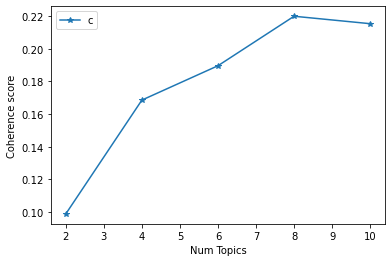

In [31]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, 
                                                        texts=data_words_negative, start=2, 
                                                        limit=12, step=2)
# Show graph
import matplotlib.pyplot as plt
limit=12; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values, '*-')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [32]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=8,random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,                                             
    alpha='auto',
    per_word_topics=True)

# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.098*"quot" + 0.088*"work" + 0.061*"back" + 0.028*"weekend" + 0.022*"next" '
  '+ 0.019*"pleas" + 0.017*"talk" + 0.017*"done" + 0.014*"long" + '
  '0.013*"plan"'),
 (1,
  '0.057*"time" + 0.053*"happi" + 0.052*"new" + 0.032*"school" + 0.027*"hey" + '
  '0.026*"use" + 0.022*"yeah" + 0.019*"take" + 0.019*"show" + '
  '0.017*"birthday"'),
 (2,
  '0.070*"good" + 0.063*"day" + 0.037*"like" + 0.028*"one" + 0.022*"think" + '
  '0.022*"week" + 0.022*"well" + 0.022*"go" + 0.020*"amp" + 0.018*"realli"'),
 (3,
  '0.077*"get" + 0.034*"got" + 0.026*"come" + 0.024*"want" + 0.024*"fun" + '
  '0.021*"start" + 0.021*"home" + 0.021*"thing" + 0.019*"sun" + 0.018*"last"'),
 (4,
  '0.066*"twitter" + 0.064*"hope" + 0.059*"follow" + 0.049*"look" + '
  '0.035*"need" + 0.032*"still" + 0.028*"right" + 0.026*"better" + '
  '0.021*"soon" + 0.015*"tell"'),
 (5,
  '0.091*"thank" + 0.082*"morn" + 0.036*"make" + 0.032*"monday" + 0.029*"much" '
  '+ 0.026*"haha" + 0.025*"tri" + 0.023*"yay" + 0.022*"friend" + '

### Plot a wordcloud 

In [33]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

def plot_topics(lda_model):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

    cloud = WordCloud(stopwords=my_stopwords,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    topics = lda_model.show_topics(formatted=False)

    fig, axes = plt.subplots(4, 2, figsize=(10,10), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')


    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

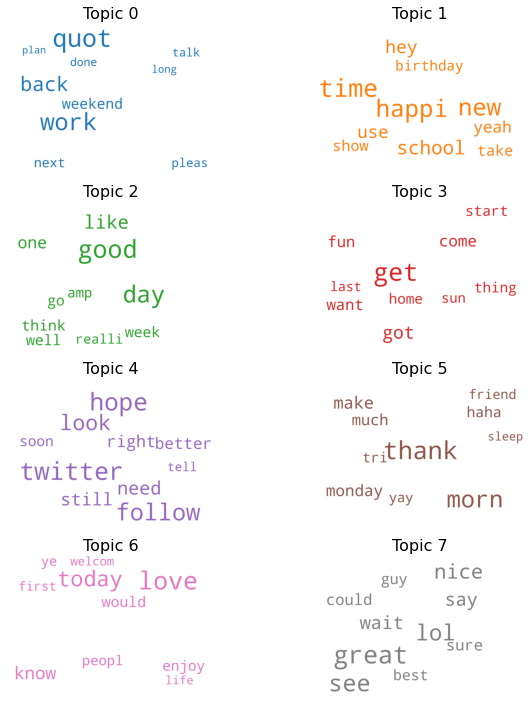

In [34]:
plot_topics(lda_model)

## Now look at the negative sentiments.

In [35]:
"""The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus.
"""
# Create Dictionary
id2word = corpora.Dictionary(data_words_negative)

# Create Corpus
texts_negative = data_words_negative

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts_negative]

### Find optimal number of topics 

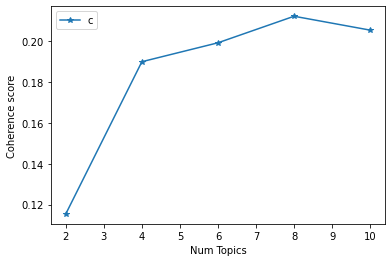

In [36]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, 
                                                        texts=data_words_negative, start=2, 
                                                        limit=12, step=2)
# Show graph
import matplotlib.pyplot as plt
limit=12; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values,'*-')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

#### Rerun with 8 topics

In [37]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=8,random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,                                             
    alpha='auto',
    per_word_topics=True)

# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.053*"back" + 0.051*"got" + 0.039*"wish" + 0.039*"quot" + 0.035*"home" + '
  '0.031*"watch" + 0.027*"hour" + 0.024*"bed" + 0.020*"sick" + 0.016*"went"'),
 (1,
  '0.072*"work" + 0.063*"get" + 0.039*"today" + 0.034*"miss" + 0.032*"go" + '
  '0.030*"still" + 0.019*"hope" + 0.019*"love" + 0.017*"though" + '
  '0.015*"week"'),
 (2,
  '0.071*"sleep" + 0.063*"need" + 0.062*"night" + 0.046*"see" + 0.045*"hate" + '
  '0.034*"saturday" + 0.034*"right" + 0.023*"head" + 0.022*"better" + '
  '0.019*"hurt"'),
 (3,
  '0.060*"good" + 0.028*"lol" + 0.026*"gonna" + 0.023*"way" + 0.018*"use" + '
  '0.018*"anoth" + 0.015*"everyon" + 0.015*"gotta" + 0.015*"bit" + '
  '0.014*"far"'),
 (4,
  '0.040*"amp" + 0.029*"bore" + 0.029*"twitter" + 0.027*"cant" + 0.024*"thing" '
  '+ 0.021*"yet" + 0.018*"yeah" + 0.017*"sun" + 0.016*"find" + 0.015*"man"'),
 (5,
  '0.046*"want" + 0.045*"like" + 0.039*"feel" + 0.038*"time" + 0.036*"realli" '
  '+ 0.031*"last" + 0.029*"think" + 0.028*"know" + 0.024*"sad" + 0.022*

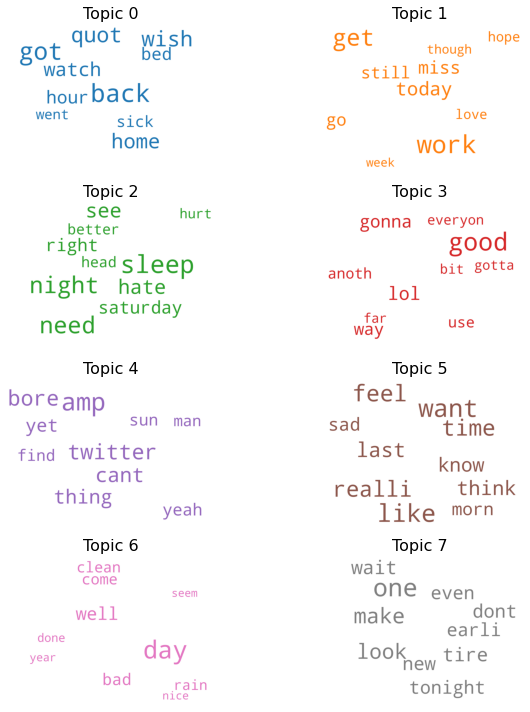

In [38]:
plot_topics(lda_model)